In [1]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
spam_path = "../input/spam-text-message-classification/SPAM text message 20170820 - Data.csv"
df = pd.read_csv(spam_path)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
X = df.Message
Y = df.Category
X.head(3), Y.head(3)

(0    Go until jurong point, crazy.. Available only ...
 1                        Ok lar... Joking wif u oni...
 2    Free entry in 2 a wkly comp to win FA Cup fina...
 Name: Message, dtype: object,
 0     ham
 1     ham
 2    spam
 Name: Category, dtype: object)

In [4]:
whole_text = ''
for i in X:
    whole_text += i + ' '

In [5]:
stop_words = stopwords.words("english")
def clean_text(text):
    text = text.lower()           # converting to lowercase
    text = re.sub("@\S+", " ", text)  
    text = re.sub("https*\S+", " ", text)      #\S - не пробел 
    text = re.sub("www\S+", " ", text)
    text = re.sub("#\S+", " ", text)
    text = re.sub("\d", " ", text)        # remove all numbers
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)     # remove punctuations
    text = re.sub('\n', ' ', text)        
    text = re.sub('\s{2,}',' ', text)        # remove extra spaces
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    return text

In [6]:
whole_text_clean = clean_text(whole_text)
#whole_text_clean[:120]

In [7]:
tokens = word_tokenize(whole_text_clean)
#tokens[:9]

In [8]:
lemmatizer = WordNetLemmatizer()
lemtokens= [lemmatizer.lemmatize(t) for t in tokens]
#lemtokens[:9]

In [9]:
dictionary = list(set(lemtokens)) # set() - неупордоченый набор , list() - упордоченный список
#dictionary[:7]
#dims = len(dictionary)   dims - 7133

In [10]:
def convert(text):
    text = clean_text(text)
    tok = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(t) for t in tok]
    res = [dictionary.index(i) for i in lem]
    return res

In [11]:
X = X.apply(convert)
X.head(3)

0    [5145, 4756, 5716, 5161, 1333, 3230, 4208, 380...
1                 [6624, 6173, 5053, 6559, 4010, 3137]
2    [5996, 3387, 4603, 2700, 2994, 6842, 6907, 273...
Name: Message, dtype: object

In [12]:
def encoding(text):
    if text == 'ham':
        return 0
    elif text == 'spam':
        return 1
    else:
        return -1

In [13]:
Y = Y.apply(encoding) 

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [15]:
print('X_train', len(X_train))
print('Y_test', len(Y_test))
X_train.shape

X_train 4457
Y_test 1115


(4457,)

In [16]:
y_train = np.asarray(Y_train).astype("float32")
y_test = np.asarray(Y_test).astype("float32")

In [17]:
# Only consider the first 50 words
x_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen = 50)
x_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen = 50)

In [18]:
x_train.shape

(4457, 50)

In [19]:
model = keras.Sequential()
model.add(layers.Embedding(7500, 64)) 
model.add(layers.LSTM(128))
model.add(layers.Dense(1, activation = 'sigmoid'))


User settings:

   KMP_AFFINITY=granularity=fine,noverbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER

In [20]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]

model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

history = model.fit(x_train,
                    y_train,
                    epochs = 5,
                    batch_size = 128,
                    validation_split = 0.2,
                    shuffle = True,
                    callbacks = my_callbacks,
                    verbose = 2)

2022-01-31 09:40:30.825735: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
28/28 - 6s - loss: 0.4164 - accuracy: 0.8665 - val_loss: 0.3132 - val_accuracy: 0.8576
Epoch 2/5
28/28 - 4s - loss: 0.1650 - accuracy: 0.9403 - val_loss: 0.1449 - val_accuracy: 0.9619
Epoch 3/5
28/28 - 4s - loss: 0.0571 - accuracy: 0.9857 - val_loss: 0.0775 - val_accuracy: 0.9776
Epoch 4/5
28/28 - 4s - loss: 0.0272 - accuracy: 0.9924 - val_loss: 0.0630 - val_accuracy: 0.9809
Epoch 5/5
28/28 - 4s - loss: 0.0140 - accuracy: 0.9972 - val_loss: 0.0694 - val_accuracy: 0.9798


In [21]:
len(history.history['loss'])

5

In [22]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          480000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 578,945
Trainable params: 578,945
Non-trainable params: 0
_________________________________________________________________
None


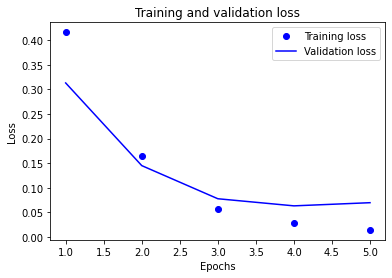

In [23]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [24]:
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.06345344334840775
Test accuracy: 0.9847533702850342
